Written by [Samuel Adekunle](mailto:sja119@ic.ac.uk)

For [AI Core](http://www.theaicore.com)

# Introduction to Autoencoders

## Uses of Autoencoders

### Image/Audio Denoising

Autoencoders are very good at removing noise from images and generating a much clearer picture than the original. Later we will see how this can easily be implemented.

![image](img/denoising_example.png)

### Image Generation

An alternative to GANs are a variant of autoencoders known as [Variational Autoencoders](https://en.wikipedia.org/wiki/Autoencoder#Variational_autoencoder_(VAE)). There's a lot of complicated math involved but in summarhy, te input is an image, and the variational autoencoder learns it's distribution and can generate similar images.

![faces generated with a vae](img/faces.png)

*Faces generated with a Variational Autoencoder Model (source: [Wojciech Mormul on Github](https://github.com/WojciechMormul/vae))*

### Image Inpainting and Photo Restoration

![context encoders](img/inpainting.jpg)

*Faces generated with a Variational Autoencoder Model (source: [Context Encoders: Feature Learning by Inpainting](https://people.eecs.berkeley.edu/~pathak/context_encoder/))*

### Other Uses:
 - Anomaly Detection and Facial Recogniton
 - Feature Extraction and Data Compression
 - Language Translation


## Autoencoder Basic Architecture

An [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder) is a neural network architecture that learns efficient data encodings in an unsupervised manner. What this means is autoencoders learn to recognise the most important features of the data they are fed, and reject the less important ones (i.e. noise). In doing so, they can reduce the dimensionality of the number of features needed to represent the same data. It does this in two steps:

 - Data Encoding: The input data is forced through a bottleneck and transfomed into a feature space, which is typically much smaller than the input space. The encoder is trained so that this feature space represents the most important features in the input space that are needed to reconstruct the data. Note: If the feature space is not smaller than the input space, then the encoder might just learn the identity function.
 
 - Data Decoding: After the input data has been reduced to some feature space, the autoencoder tries to reconstruct the original data from the reduced feature space. This is why an autoencoder is often said to undergo **unsupervised training**. The original input data is what is compared against the output of the network and used to train it. Typically in training the autoencoder, the network tries to minimize a reconstruction loss, such as the Mean Squared Error between the input and the output.

![image](img/transitions.png)

*Mathematical Definition of an Autoencoder (source: [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder))*

# Feed-Forward Autoencoder

This basic architechture will take the input and try to reproduce it at the output.

![feed_foward_autoencoder](img/encoder_decoder.png)

*Basic Reconstruction Autoencoder Architecture (source: [Jeremy Jordan](https://www.jeremyjordan.me/autoencoders/))*

In [1]:
# All requirements for this notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np


SEED = 5000
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# We will be using popular MNIST dataset
train_data = torchvision.datasets.MNIST(root='MNIST-data',
                                        transform=torchvision.transforms.ToTensor(),
                                        train=True,
                                        download=True
                                        )
test_data = torchvision.datasets.MNIST(root='MNIST-data',
                                       transform=torchvision.transforms.ToTensor(),
                                       train=False
                                       )

In [3]:
print(f"Shape of MNIST Training Dataset: {train_data.data.shape}")
print(f"Shape of MNIST Testing Dataset: {test_data.data.shape}")

Shape of MNIST Training Dataset: torch.Size([60000, 28, 28])
Shape of MNIST Testing Dataset: torch.Size([10000, 28, 28])


In [4]:
def show_image_helper(image):
    image = image.view(28, 28)
    plt.imshow(image.cpu().detach())
    plt.show()
    print("Max Element: ", rdm_img.max())
    print("Min Element: ", rdm_img.min())
    
def show_losses_helper(losses):
    plt.plot(losses[1:])
    plt.ylabel("Losses")
    plt.xlabel("Epochs")
    plt.title("Autoencoder Losses")
    plt.show()

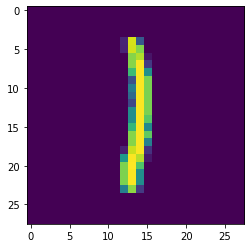

Max Element:  tensor(1.)
Min Element:  tensor(0.)


In [5]:
# What are we working with and what will we be doing
rdm_img = train_data.data[np.random.randint(
    0, 100)] / 255.0  # get a random example
show_image_helper(rdm_img)

In [6]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [
                                                     50000, 10000])

BATCH_SIZE = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(  # create a data loader
    train_data,  # what dataset should it sample from?
    shuffle=True,  # should it shuffle the examples?
    batch_size=BATCH_SIZE  # how large should the batches that it samples be?
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, code_size):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, code_size),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(code_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [8]:
def train(model, num_epochs=10, learning_rate=0.01):
    global EPOCHS
    model.train()
    losses = []
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
#     criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        EPOCHS += 1
        total_loss = 0
        num_batches = 0
        for org_img, _ in train_loader:
            optimiser.zero_grad()

            org_img = org_img.double().view(-1, 784).to(device) / 255.0
            gen_img = model(org_img).double()

            loss = criterion(gen_img, org_img)
            total_loss += loss
            num_batches += 1

            loss.backward()  # backpropagate
            optimiser.step()
        
        average_loss = total_loss / num_batches
        losses.append(average_loss)
        print(f"Epoch {EPOCHS}:\tScore: {1/average_loss}")
    
    return losses

In [9]:
EPOCHS = 0
INPUT_SIZE = 28*28
HIDDEN_SIZE = 128
CODE_SIZE = 32
LEARNING_RATE = 0.01

autoencoder = AutoEncoder(
    INPUT_SIZE, HIDDEN_SIZE, CODE_SIZE).double().to(device)

Epoch 1:	Score: 65.9746830403687
Epoch 2:	Score: 253.71439743573538
Epoch 3:	Score: 254.1112540841705
Epoch 4:	Score: 254.6927016062727
Epoch 5:	Score: 255.29870898289508
Epoch 6:	Score: 256.4334503161277
Epoch 7:	Score: 257.90301234822346
Epoch 8:	Score: 259.5075457397731
Epoch 9:	Score: 260.4631195092867
Epoch 10:	Score: 261.1034743810059
Epoch 11:	Score: 261.6928707329267
Epoch 12:	Score: 262.2515987754876
Epoch 13:	Score: 262.90792133414806
Epoch 14:	Score: 264.5439896168884
Epoch 15:	Score: 266.52383513231877
Epoch 16:	Score: 267.958849893919
Epoch 17:	Score: 269.1381944234346
Epoch 18:	Score: 270.09315124139346
Epoch 19:	Score: 270.8515580173019
Epoch 20:	Score: 271.4857478976898
Epoch 21:	Score: 272.0478296076016
Epoch 22:	Score: 272.7034256223991
Epoch 23:	Score: 273.1984607430912
Epoch 24:	Score: 273.837528485409
Epoch 25:	Score: 274.55321836051


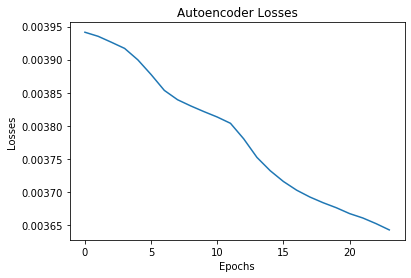

In [10]:
num_epochs = 25
losses = train(autoencoder, num_epochs, LEARNING_RATE)
show_losses_helper(losses)

In [11]:
def validate(model):
    model.eval()
    criterion = torch.nn.BCELoss()
#     criterion = torch.nn.MSELoss()
    total_loss = 0
    num_batches = 0
    for val_img, _ in val_loader:
        val_img = val_img.double().view(-1, 784).to(device) / 255.0
        gen_img = model(val_img).double()
        loss = criterion(gen_img, val_img)
        total_loss += loss
        num_batches += 1
    average_loss = total_loss / num_batches
    return 1/average_loss.item()

In [12]:
score = validate(autoencoder)
print("Score: ", score)

Score:  273.6599220477289


In [13]:
def test(model):
    model.eval()
    criterion = torch.nn.BCELoss()
#   criterion = torch.nn.MSELoss()
    total_loss = 0
    num_batches = 0
    stored_images = []
    for test_img, _ in test_loader:
        test_img = test_img.double().view(-1, 784).to(device) / 255.0
        gen_img = model(test_img)
        loss = criterion(gen_img.double(), test_img).item()
        total_loss += loss
        num_batches += 1
        if np.random.random() > 0.90:
            stored_images.append(
                (test_img[0].clone().detach(), gen_img[0].clone().detach()))

    score = average_loss = total_loss / num_batches
    print(f"Score: {1/score}\n")

    for original, generated in stored_images:
        print("Original: ")
        show_image_helper(original)
        print("Generated: ")
        show_image_helper(generated)

Score: 271.5048760406239

Original: 


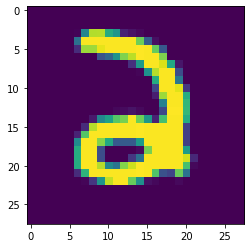

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


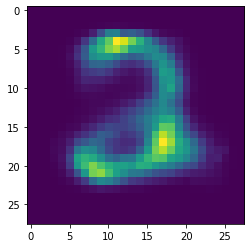

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


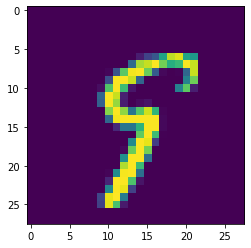

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


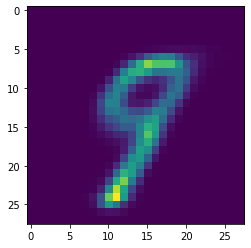

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


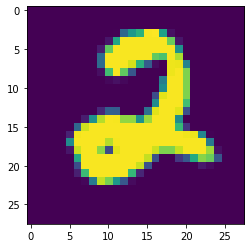

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


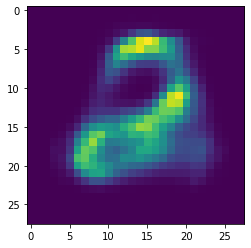

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


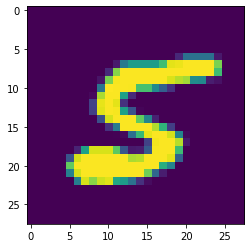

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


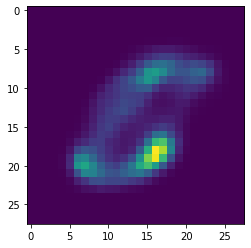

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


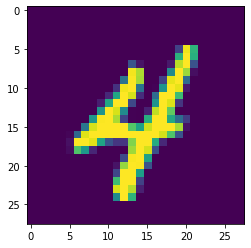

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


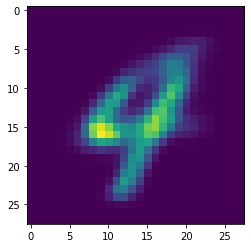

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


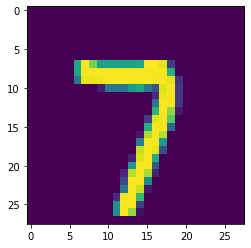

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


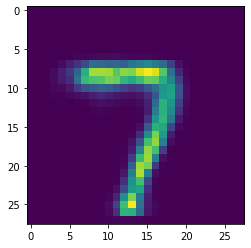

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


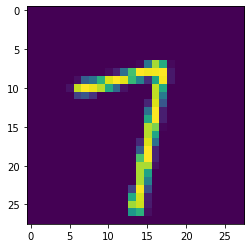

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


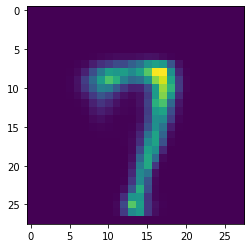

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


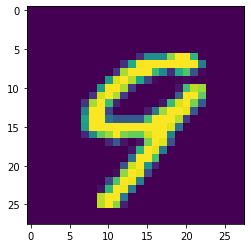

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


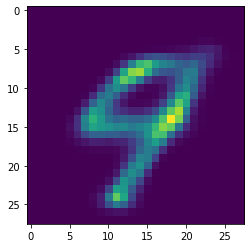

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


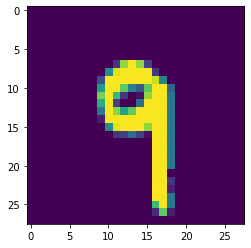

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


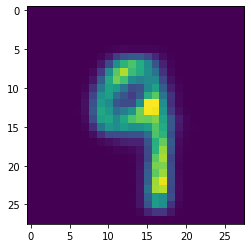

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


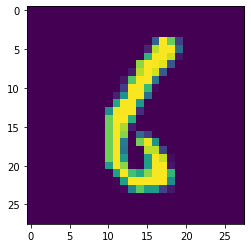

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


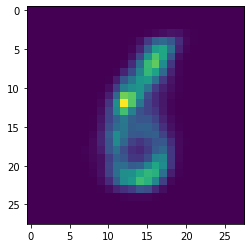

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


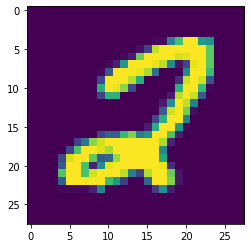

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


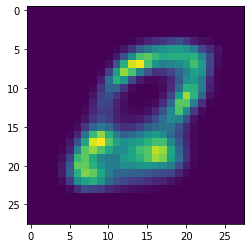

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


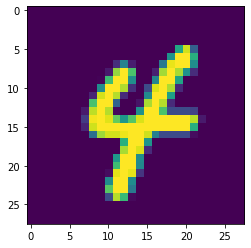

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


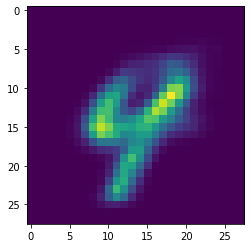

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


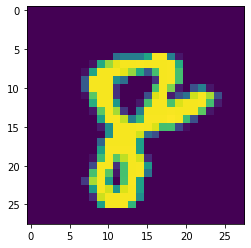

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


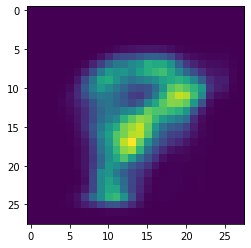

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


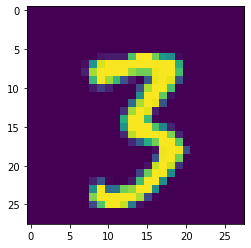

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


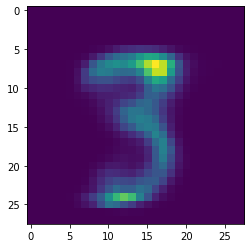

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


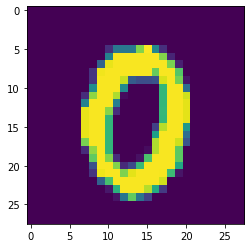

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


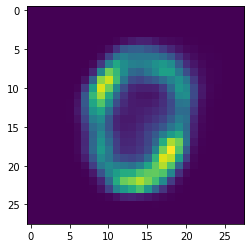

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


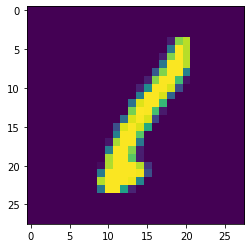

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


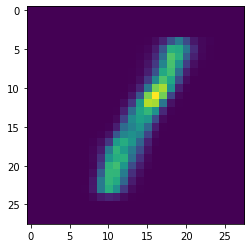

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


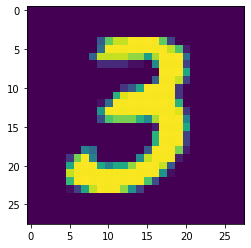

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


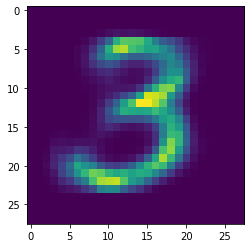

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


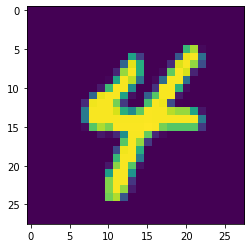

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


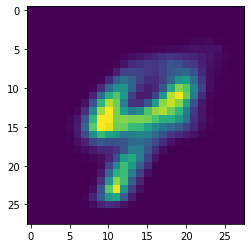

Max Element:  tensor(1.)
Min Element:  tensor(0.)


In [14]:
test(autoencoder)

## Comparing MSE to BCE

Generally, when dealing with Autoencoders or similar problems, we train using a loss like MSE which would compare the generated image and the original one, pixel by pixel in order to calculate the error. 

This is fine most of the time, but would not have been optimal in our case. Our images have values varying only between 0 and 1 and most of them are zero anyways, so this means the mean square error will always be very low, which will not allow our model to train effectively.

![mean_square_error_loss](img/mse_losses.png)

The alternative we used was the Binary Cross Entropy Error. Typically this is used for categorical problems, but in our case we are trying to distinguish between a high (1.0) and a low(0.0) so the cross entropy loss can still be used. Because our numbers are between 0 and 1 we use a binary cross entropy.

![binary_cross_entropy_loss](img/bce.png)

# Application - Denoising an Image

This adds some noise to the input before passing it in to the autoencoder network but uses the original image as the ground truth, effectively training the autoencoder network to reject the noise and learn the data encodings that represent the data beneath the noise. The only difference is in the training loop

![denoising_autoencoder_architecture](img/denoising.png)

*Denoising Autoencoder Architecture (source: [Jeremy Jordan](https://www.jeremyjordan.me/autoencoders/))*


In [15]:
def add_noise(clean_image, noise_factor=0.0):
    random_noise = torch.randn_like(clean_image)
    random_noise /= random_noise.max() # between -1 and 1
    noisy_image = clean_image + (noise_factor * random_noise)
    return noisy_image

In [16]:
def train_noise(model, num_epochs=10, learning_rate=0.01, noise_factor=0.0):
    global EPOCHS
    model.train()
    losses = []
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
#     criterion = nn.MSELoss()

    for _ in range(num_epochs):
        EPOCHS += 1
        total_loss = 0
        num_batches = 0
        for org_img, _ in train_loader:
            optimiser.zero_grad()
            org_img = org_img.double().view(-1, 784).to(device) / 255.0
            noisy_img = add_noise(org_img, noise_factor)
            gen_img = model(noisy_img).double()

            loss = criterion(gen_img, org_img)
            total_loss += loss
            num_batches += 1

            loss.backward()  # backpropagate
            optimiser.step()

        average_loss = total_loss / num_batches
        losses.append(average_loss)
        print(f"Epoch {EPOCHS}:\tScore: {1/average_loss}")
    return losses

In [17]:
EPOCHS = 0
INPUT_SIZE = 28*28
HIDDEN_SIZE = 128
CODE_SIZE = 32
LEARNING_RATE = 0.01
NOISE_FACTOR = 0.001

denoise_autoencoder = AutoEncoder(
    INPUT_SIZE, HIDDEN_SIZE, CODE_SIZE).double().to(device)

Epoch 1:	Score: 59.75679771690447
Epoch 2:	Score: 251.18074917481994
Epoch 3:	Score: 252.6921020280419
Epoch 4:	Score: 254.09790694141552
Epoch 5:	Score: 254.819997697417
Epoch 6:	Score: 255.6102181550768
Epoch 7:	Score: 256.63636913198377
Epoch 8:	Score: 257.94384904717685
Epoch 9:	Score: 258.76483061365417
Epoch 10:	Score: 259.70921886758015
Epoch 11:	Score: 260.5467640070574
Epoch 12:	Score: 260.9838936349969
Epoch 13:	Score: 261.37337065872185
Epoch 14:	Score: 262.5729687955811
Epoch 15:	Score: 264.4646967983865
Epoch 16:	Score: 265.9826024554563
Epoch 17:	Score: 266.93235612723765
Epoch 18:	Score: 267.65796666980407
Epoch 19:	Score: 268.40720731143205
Epoch 20:	Score: 269.01269006078854
Epoch 21:	Score: 269.60631692091505
Epoch 22:	Score: 270.46841955209504
Epoch 23:	Score: 271.47174606097565
Epoch 24:	Score: 272.0981936757506
Epoch 25:	Score: 272.5683784998365


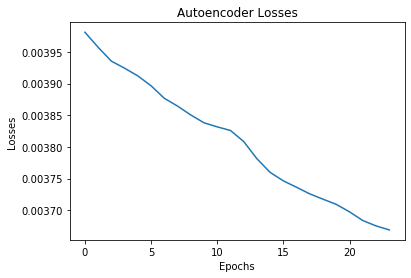

In [18]:
num_epochs = 25
losses = train_noise(denoise_autoencoder, num_epochs, LEARNING_RATE, NOISE_FACTOR)
show_losses_helper(losses)

In [19]:
def validate_noise(model, noise_factor=NOISE_FACTOR):
    model.eval()
    criterion = torch.nn.BCELoss()
#     criterion = torch.nn.MSELoss()
    total_loss = 0
    num_batches = 0
    for val_img, _ in val_loader:
        val_img = val_img.double().view(-1, 784).to(device) / 255.0
        gen_img = model(add_noise(val_img, noise_factor)).double()

        loss = criterion(gen_img, val_img)
        total_loss += loss
        num_batches += 1
    average_loss = total_loss / num_batches
    return 1/average_loss.item()

In [20]:
score = validate_noise(denoise_autoencoder)
print("Score: ", score)

Score:  272.01511380963933


In [21]:
def test_noise(model, noise_factor=NOISE_FACTOR):
    model.eval()
    criterion = torch.nn.BCELoss()
#   criterion = torch.nn.MSELoss()
    total_loss = 0
    num_batches = 0
    stored_images = []
    for test_img, _ in test_loader:
        test_img = test_img.double().view(-1, 784).to(device) / 255.0
        noisy_img = add_noise(test_img, noise_factor)
        gen_img = model(noisy_img).double()
        
        loss = criterion(gen_img, test_img)
        total_loss += loss
        num_batches += 1
        if np.random.random() > 0.90:
            stored_images.append((test_img[0].clone().detach(
            ), noisy_img[0].clone().detach(), gen_img[0].clone().detach()))

    score = average_loss = total_loss / num_batches
    print(f"Score: {1/score}\n")

    for original, noisy, generated in stored_images:
        print("Original: ")
        show_image_helper(original)
        print("Noisy: ")
        show_image_helper(noisy)
        print("Generated: ")
        show_image_helper(generated)

Score: 269.54182307638195

Original: 


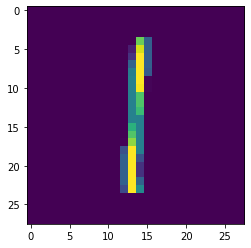

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


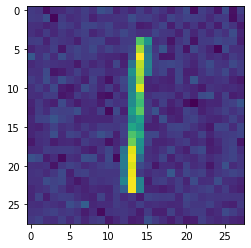

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


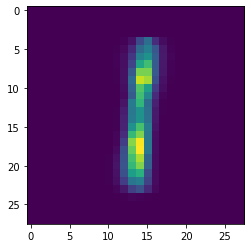

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


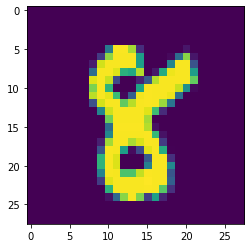

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


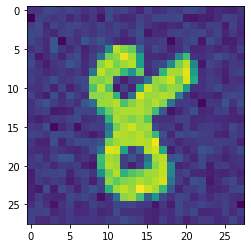

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


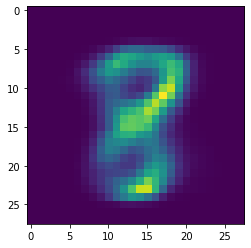

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


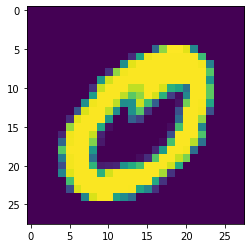

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


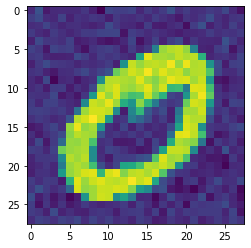

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


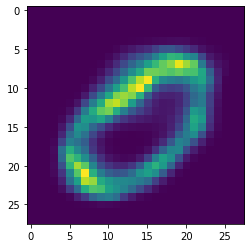

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


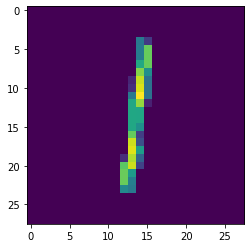

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


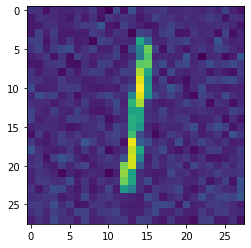

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


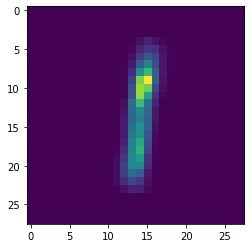

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


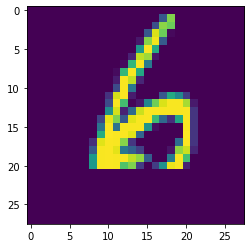

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


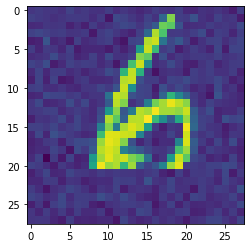

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


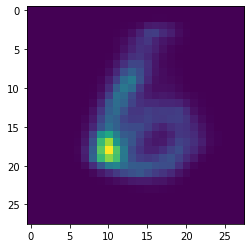

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


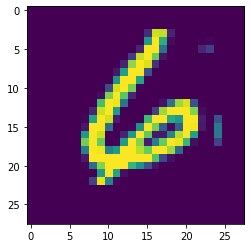

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


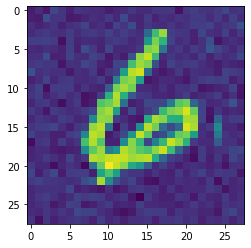

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


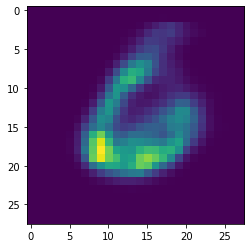

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


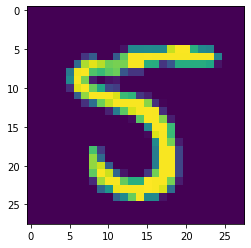

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


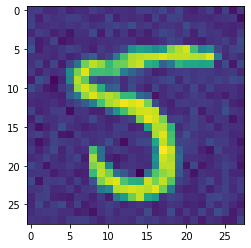

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


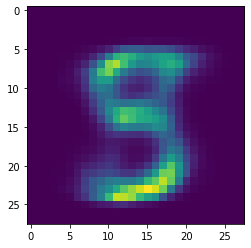

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


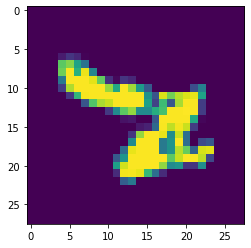

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


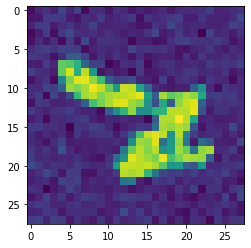

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


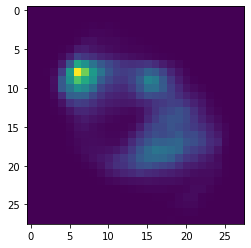

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


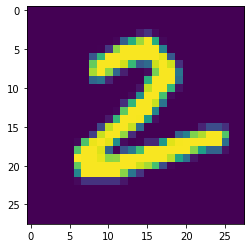

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


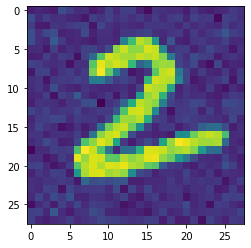

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


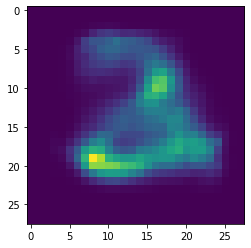

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


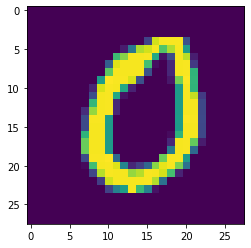

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


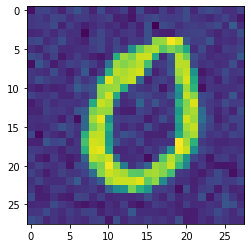

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


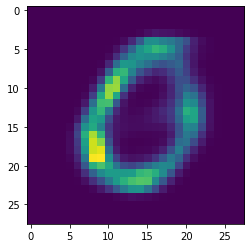

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


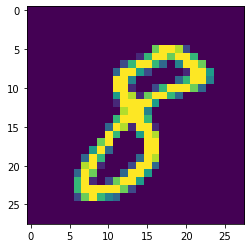

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


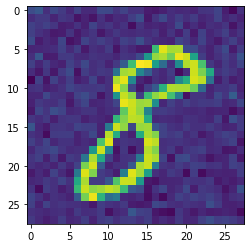

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


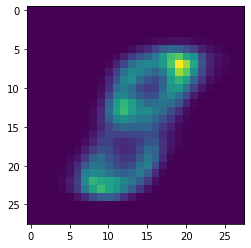

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


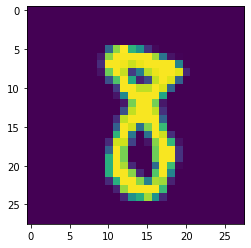

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


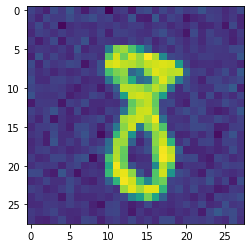

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


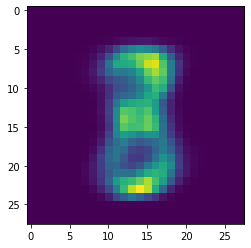

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


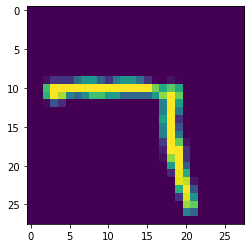

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


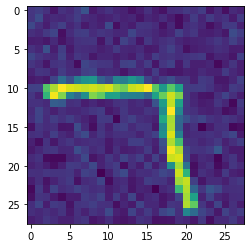

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


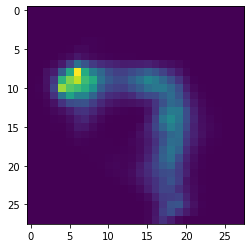

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


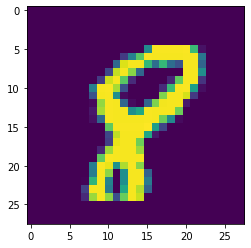

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


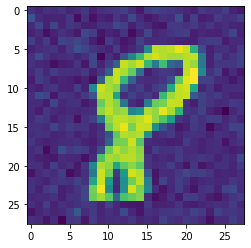

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


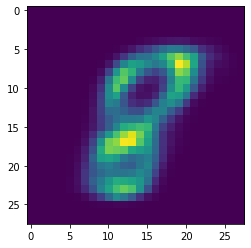

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


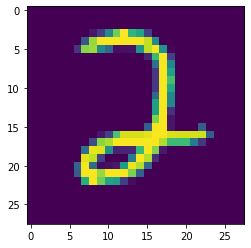

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


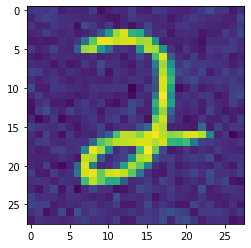

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


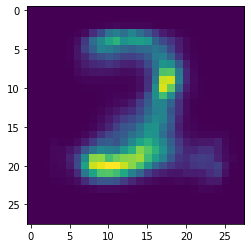

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Original: 


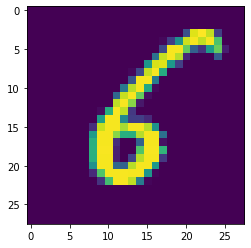

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Noisy: 


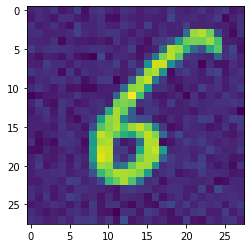

Max Element:  tensor(1.)
Min Element:  tensor(0.)
Generated: 


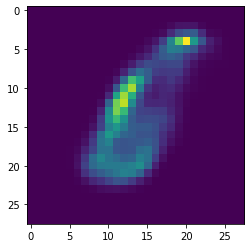

Max Element:  tensor(1.)
Min Element:  tensor(0.)


In [22]:
test_noise(denoise_autoencoder)